# Deeper Neural Networks-- Multi-Layer Perceptrons Lab

In this lab, we'll extend our neural networks knowledge further and add one hidden layer in our neural network, which is commonly referred to as a **_Multi-Layer Perceptron (MLP)_**!

We'll perform forward propagation, backward propagation, and work with activation functions we haven't used before: the hyperbolic tangent or "tanh" activation function. Let's get started!

# 1. Import packages and generate the data

Let's first start with importing the necessary libraries. We'll use plotting as well as numpy. Additionally, we'll generate our own data using scikit-learn, so we have to use that library as well.

In [1]:
# Package imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
import sklearn
from sklearn.datasets import make_classification
import sklearn.linear_model

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

Next, let's generate our data. Scikit-learns enables the creation of simple toy datasets to visualize clustering and classification algorithms. One of them is called `make_circles` and generates a a large circle containing a smaller circle in 2D. `make_circles`-function has several arguments, but here we'll just use 2: `n_samples` and `noise`. We'll create a data set with 500 samples, and insert noise equal to 0.1.

Run the cell below to create and plot our sample dataset and the corresponding labels. 

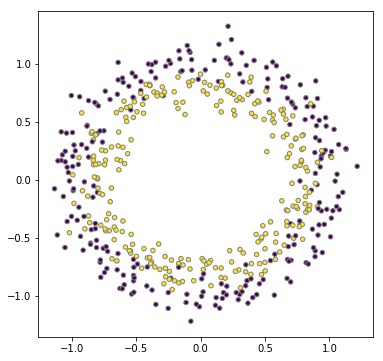

In [2]:
# Generate a dataset and plot it
np.random.seed(123)
sample_size = 500
X, Y = sklearn.datasets.make_circles(n_samples = sample_size, noise = 0.1)
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
plt.scatter(X[:,0], X[:,1], s=20, c=Y, edgecolors="gray")

Note that we just generated to "classes": the yellow dots and the purple dots. The goal of this lab is to create a model which can create a **_Decision Boundary_** to distinguish the smaller (yellow) circle from the larger (purple) one.

We'll build a neural network to do this. But first, let's build a logistic regression model and see how that model performs. We'll use this as a benchmark to compare against our MLP.

# 2. Build a logistic regression model

Use the Scikit-learn function `linear_model.LogisticRegression()` to build a logistic regression model. 

Then, `.fit()` the object to `X` and `Y`.

In [3]:
log_reg = sklearn.linear_model.LogisticRegression()
log_reg.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In the cell below, we've provided a helper function that will allow us to visualize the results of our classifier by plotting the decision boundary.  You'll use this helper function to visualize the classification performance.

Run the cell below to create the helper function `plot_decision_boundary()`.

In [4]:
# We got this helper function online to create a decision boundry
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .3, X[:, 0].max() + .3
    y_min, y_max = X[:, 1].min() - .3, X[:, 1].max() + .3
    h = 0.005
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z)
    plt.scatter(X[:, 0], X[:, 1],s=20, c=Y ,edgecolors="gray")

In the helper function, let's create a lambda function inside `plot_decision_boundary` in order to create a decision boundary using the predictions made by the logistic regression model `log_reg`.

In the cell below, call `plot_decision_boundary()` and pass in a lambda function called `x`, which should be equal `log_reg.predict(x)`.  



Text(0.5,1,'Logistic Regression')

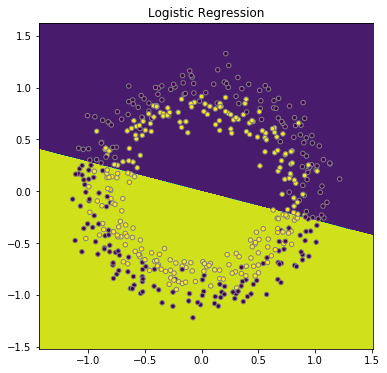

In [5]:
plot_decision_boundary(lambda x: log_reg.predict(x))
plt.title("Logistic Regression")

Now explicitly store the predictions using `X` in `log_reg_predict`, so we can calculate the accuracy.

In the cell below, call `log_reg_predict(X)` and store the results that it returns inside of `log_reg_predict`

In [6]:
log_reg_predict = log_reg.predict(X)

In [7]:
print ('The logistic regression model has an accuracy of: ' 
       + str(np.sum(log_reg_predict == Y)/sample_size*100) + '%')

The logistic regression model has an accuracy of: 51.2%


**How did this model perform? Is this a surprise? Why do you think the model wasn't able to perform better?**

Write your answer below this line:
______________________________________________________________________________________________________________________

The model performed no better than a coin flip.  This is not surprising, because the logistic regression is only able to plot a linear decision boundary, but our data is not linearly separable--it is impossible to draw a straight line anywhere on the plot that would accurately separate the two classes of data points.  

# 3. Building a Multi-Layer Perceptron

## 3.1 network architecture and data pre-processing

A **_Multi-Layer Perceptron (MLP)_** is a perceptron with at least one **_Hidden Layer_** in between our input layer and our output layer.  MLPs belong to the family of algorithms that are considered **_Neural Networks_**.

Let's see if a neural network can do better. In what follows, you'll build a neural network with one hidden layer (the hidden layer has 6 units, as follows):

![title](figures/lab_2_graph.png)

Let's reintroduce some of the terminology.

- remember that the input layer passes on $a^{[0]}$ to the next layer, which simply is equal to $x = (x_1, x_2)$. 



- The hidden layer passes on $a^{[1]} = \begin{bmatrix} a^{[1]}_1  \\a^{[1]}_2 \\ a^{[1]}_3 \\ a^{[1]}_4\\ a^{[1]}_5\\ a^{[1]}_6\end{bmatrix}$  

- This sort of notation is common for describing the architecture of a layer in a Neural Network.  The top number inside of brackets denotes the **_layer_** that the neuron belongs to, while the bottom number denotes the index of the neuron inside its corresponding layer. 



- The final layer outputs $a^{[2]}$ which is $\hat y$.



Note that the input layer has 2 inputs, $x_1$ and $x_2$ (which are basically the x- and y-coordinates in the graph with the two circles above). Let's look at the shape of the X-matrix.

In the cell below, check the `.shape` attribute of our data.

In [8]:
X.shape

(500, 2)

Run the cell below to examine an example row from our dataset.

In [9]:
X[1, :]

array([-0.59496605,  0.68087477])

Remember that for the neural networks, we want the number of inputs to be rows and the number of cases to be columns. Hence we transpose this matrix.  By transposing our our data, we make it easy to compute the dot-product of our weights, which are "tall and skinny", with our inputs, which are now "short and fat".  

In the cell below, set `X_nn` equal to the transpose of `X`

**_HINT:_** Use the `.T` attribute!

In [10]:
X_nn = X.T

Run the cell below to display the first row of data from our transposed data. 

In [11]:
X_nn[1, :]

array([-0.37828961,  0.68087477,  0.81429484, -0.77378268,  0.85892749,
       -0.10865614,  0.20730929, -0.87224764, -0.73579453, -0.0926102 ,
        0.56140523,  0.26307058,  0.82225853,  0.51783703, -0.23140602,
        0.20598722,  0.00835862, -0.72464625, -0.89881771, -0.26693974,
        0.68544827,  0.84333494, -0.81241683,  0.49591323, -0.34920645,
        0.75995611,  0.64301122,  0.95135647, -0.85200556, -0.90646813,
        0.01797516,  1.01623139,  0.29426925,  0.69318823,  0.38080862,
        0.84690032, -1.11085978,  0.70860272,  0.80510946,  0.58217633,
        0.14085883,  0.24496351, -0.97413823, -0.504137  ,  1.00340667,
        0.58364276,  0.25625499, -1.09688449,  0.47898605,  0.89323154,
        0.73895865, -1.05994125,  0.43705045,  0.25145363, -0.51097946,
       -0.77388344,  0.81929174,  0.08702704,  0.85137072, -0.07734176,
       -0.38752931, -0.4626274 ,  0.98360288,  0.84509431, -0.07063259,
       -0.61780628,  0.72732415, -0.75527131, -0.93907278, -1.07

Similarly, for the labels, we like to have a row-matrix.

In the cell below, reshape our labels to a shape of `(1, 500)`  using `np.reshape()`.  Store the results returned inside of `Y_nn`.

In [12]:
Y_nn = np.reshape(Y,(1,500))

Run the cell below to display the shape of our reshaped data and labels.

In [13]:
np.shape(X_nn), np.shape(Y_nn)

((2, 500), (1, 500))

As per the network architecture above, there are two nodes in the input layer, and 1 node in the output layer (with a sigmoid activation). will create three objects to store the size of each layer: `n_0`, `n_1` and `n_2`. `n_0` (input layer size) and `n_2` (output layer size) are defined by the data, `n_1` is a hyperparameter and can be changed to optimize the result! For this exercise, we've chosen to have 6 nodes in the hidden layer, so let's hardcode the size `n_1` equal to 6. 

In [14]:
n_0 = np.shape(X_nn)[0]
n_1 = 6
n_2 = np.shape(Y_nn)[0] 

# 3.2 Forward & Backward Propagation

Neural Networks have two major processes: **_Forward Propagation_** and **_Back Propagation_**.  During Forward Propagation, we start at the input layer and feed our data in, propagating it through the network until we've reached the output layer and generated a prediction.  

**_Back Propagation_** is essentially the opposite of Forward Propagation.  In the Forward Propagation step, we start at the beginning and work towards the end of the network.  In Back Propagation, we start at the end of the Neural Network--the prediction we ended up with as a result of Forward Propagation--and work backwards, allowing our model to "learn" by comparing our prediction with the actual label for the training data. 

## Implementing Forward Propagation

To implement Forward Propagation, we'll start at the input layer and repeat the following steps until we reach the end fo the network, the output of the output layer:

1. Calculate $Z$ by taking the dot product of the layer's weights and the inputs from the previous layer (this step is called the **_Transfer Function_**) 
2. Pass Z into our **_Activation Function_**.  
3. Repeat, using the output of the Activation Function as the input for the next layer. 

Note that we can actually start with the first hidden layer, since we don't actually need to do any computations in the input layer.

Let's start forward propagating from $a^{[0]}$ to $a^{[1]}$. Note that we compute for each sample $x^{(i)}= (x_{1}^{(i)},x_{2}^{(i)})$, we compute $a^{[1] (i)}$:
First, let's get to $z^{[1] (i)}$ using $W^{[1]}$ and  $b^{[1]}$:

$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}$$ 

Then, we'll use the hyperbolic tangent function as an activation function to get to $a^{[1] (i)}$.

$$a^{[1] (i)} = \tanh(z^{[1] (i)})$$


In this example, $W^{[1]}$ is a (6 x 2)-matrix, $b^{[1]}$ is a (6 x 1)-matrix.

Before we can do any calculations, we first need to initialize our weights!

## Where Do The Weights Come From?

We know that after sufficient training, our network will have learned the best weights--but what should they start out as?

The simple answer is to randomly intialize them to very small values. 

In order to get to $a^{[1] (i)}$, we need to initialize this $W^{[1]}$ and $b^{[1]}$. 
Let's initialize $b^{[1]}$ as a matrix of zeroes, and $W^{[1]}$ as a matrix with random number generated by the standard normal distribution, but then multiplied by 0.05 to make them smaller.

Next, let's go one step further and do the same thing for $W^{[2]}$ and $b^{[2]}$.
Recall that: 
$$z^{[2] (i)} =  W^{[2]} a^{[1](i)} + b^{[2]}$$ 

What are the correct dimensions for $W^{[2]}$ and $b^{[2]}$? Use `n_0`, `n_1` and `n_2`, and look at the network graph above to get to the right dimensions!


In the cell below, complete the `initialize_parameters()` function.  This function should:
* Take in 3 parameters, `n_0, n_1` and `n_2`.
* Initialize the weights `W1` to `np.random.rand(n_1, n_0)`, scaled down by multiplying by `0.05`
* Initialize the bias `b1` for hidden layer 1 an array of zeros of shape `(n_1, 1)` (hint: use `np.zeroes()`!)
* Initialize the weights `W2` to `np.random.randn(n_2, n_1)`, scaled down by multiplying by `0.05`
* Initialize the bias `b2` for our output layer to an array of zeroes of shape `(n_2, 1)`
* Store the variables we just initialized inside a `parameters` dictionary and return `parameters`.

In [15]:
def initialize_parameters(n_0, n_1, n_2):
    W1 = np.random.randn(n_1, n_0) * 0.05 
    b1 = np.zeros((n_1, 1))
    W2 =  np.random.randn(n_2, n_1) * 0.05 
    b2 = np.zeros((n_2, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

Now, let's initialize our parameters by calling the function we've just created and passing in the hyperparameter variables `n_0, n_1`, and `n_2` that we initialized above.  

Do this in the cell below, and store the results in variable `parameters`.

In [16]:
parameters = initialize_parameters(n_0,n_1,n_2)

Let's take a look at what the parameters have been initialized to.  Display the contents of `parameters` in the cell below.  

In [17]:
parameters

{'W1': array([[-0.02997582, -0.07553642],
        [-0.08269714,  0.09955296],
        [-0.10485724, -0.08879635],
        [-0.02520535,  0.02613895],
        [-0.0146685 ,  0.03690275],
        [ 0.02214896, -0.04430022]]), 'b1': array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]), 'W2': array([[-0.01350634, -0.00985387,  0.06591551,  0.05822   , -0.01939128,
         -0.02148505]]), 'b2': array([[ 0.]])}

Now let's perform the actual forward propagation step to calculate  $z^{[1]}, a^{[1]}, z^{[2]}$ and $a^{[2]}$. You can use the function `np.tanh()` to compute the hyperbolic tangent function. Additionally, remember that $$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)}).$$
You can compute the sigmoid as $\sigma(z^{ [2] (i)}) = \displaystyle\frac{1}{1 + \exp(z^{ [2] (i)})}$


In the cell below, complete the `forward_propagation()` function.  This function should:
* Take in two parameters, `X` and `parameters`.
* Set the initial values for the weights and biases by getting them from the `parameters` dictionary.
* Compute the output of the transfer function for hidden layer 1 by taking the dot product of `W1` and `X` and then adding the bias values stored in `b1`. 
* Compute `A1`, the output of the activation function for hidden layer 1, by passing in our `Z1` value to `np.tanh()`
* Compute `Z2` by taking the dot product of `W2` and `A1`, and then adding in bias `b2`.
* Compute our prediction, the output of the output layer, by feeding `Z2` through a sigmoid function
* Store the values computed during forward propagation inside a dictionary called `fw_out` and return it. 

In [18]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1)+b2
    A2 = 1/(1 + np.exp(-Z2))
        
    fw_out = {"Z1": Z1,
              "A1": A1,
              "Z2": Z2,
              "A2": A2}
    
    return fw_out

Now, let's use the function we just created.  In the cell below, call `forward_propagation()` and pass in `X_nn` and `parameters`.  Store the results inside of `fw_out`.

In [19]:
fw_out = forward_propagation(X_nn,parameters)

`Z1` and `A1` should be of shape `(6, 500)`, and `Z2` and `A2` should be of shape `(1, 500)`.

Inspect `Z1`, `A1`, `Z2` and `A2` and make sure that the shape of all the outputs is correct! 

In [20]:
np.shape(fw_out["Z1"])

(6, 500)

In [21]:
np.shape(fw_out["Z2"])

(1, 500)

In [22]:
np.shape(fw_out["A1"])

(6, 500)

In [23]:
np.shape(fw_out["A2"])

(1, 500)

## 3.3 Compute the cost function

In order to complete the back propagation step, we'll need to make use of a **_Cost Function_**.  For each sample in our training data, this function will compare our MLP's output (the predicted class) with the label that corresponds to each sample (the actual class). 

The cost function doesn't just tell us when we're wrong--it tells us _how_ we're wrong, which allows use gradient descent and adjust the weights in the correct direction!

**_NOTE:_** Since we have vectorized our entire dataset, we are computing the cost for every single example at the same time using linear algebra.  Thus, we are actually finding the _average_ total cost for the dataset (which is why we mutliply by 1/m). 

$a^{[2] (i)}$ provides us with the predictions on all the samples.  We can then compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) $$

**_QUESTION_**:

Why do you think we multiply by a negative in this equation? (Hint--think about this would affect gradient descent!)

Write your answer below this line:
______________________________________________________________________________________________________________________

We multiply by a negative because we need to move the opposite direction of the sign of the derivative.  If our cost is positive, that means we have overshot the correct answer. Thus, we would need to move in a negative direction in order to get to a more correct area and lower our cost. Conversely, if the cost is negative, we need to move in a positive direction to get a lower cost. 

In the cell below, complete the `compute_cost()` function.  This function should:

* Take in 3 parameters: `A2`, `Y`, and `parameters`.
* Set a variable `m` equal to the shape of `Y[1]` (use `np.shape()`)
* Compute the `log_prob` by multiplying the log of `A2` and `Y` (use `np.multiply()` and `np.log()`, respectively)
* Compute the cost--use numpy to implement the equation mentioned above!

In [24]:
def compute_cost(A2, Y, parameters):
    m = np.shape(Y)[1] 

    log_prob = np.multiply(np.log(A2),Y)
    cost = - (1/m) * np.sum(log_prob+ (1-Y)*np.log(1-A2)) 
    return cost

Now, in the cell below, get the prediction of our neural network out of `fw_out` (found under the `A2` key) and store it in the variable `A2`. 

Then, call our `compute_cost()` function and pass in `A2`, `Y_nn`, and `parameters`.

In [25]:
A2= fw_out["A2"]
compute_cost(A2, Y_nn, parameters) # Expected Output: 0.69314079305668752

0.69312938361875742

## 3.3 Backward propagation

Now that we have our cost function, we can begin writing out back propagation function!

For what you have seen in the lecture, you can use the following expressions to calculate the derivatives with respect to $z$, $W$, and $b$.

$ dz^{[2]}= a^{[2]} - y $

$ dW^{[2]} = 1/m *  dz^{[2]} a^{[1]T}$

$ db^{[2]} = 1/m * dz^{[2]} $ 

$ dz^{[1]} =  dW^{[2]T}dz^{[2]} * g'{[1]}(z^{[1]})$

$ dW^{[1]} = 1/m * dz^{[1]} x^T$

$ db^{[1]} = 1/m * dz^{[1]}$


Recall that $dz^{[1]}$ and $dz^{[2]}$ will be matrices of shape (6, 500) and (1, 500) respectively. $dz^{[1]}$ and  $dz^{[2]}$ however are matrices of size (6, 1) and (1, 1). We'll need to take the averages over the 500 columns in the matrices. You can use python code of the form ```(1/m) * np.sum(dZ1,  axis=1, keepdims=True)```. We need to apply $1/m$ to compute $dW^{[1]}$ and $dW^{[2]}$ as well.


About $g^{[1]'}(z^{[1]})$: since $g^{[1]}(z^{[1]})$ is the tanh-function, its derivative $g^{[1]'}(z^{[1]})$ is equal to $1-a^2$. You can use `np.power` to compute this.

In the cell below, complete the `back_propagation()` function.  This is, by far, the most complicated function in this lab, because we'll need to compute all of these partial derivatives.  Because of this, we've provided some direction in the form of comments inside the function.  

In [26]:
def backward_propagation(parameters, fw_out, X, Y):
    m = X.shape[1]
    
    # Get these out of the parameters dictionary
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    # Get these out of fw_out
    A1 = fw_out["A1"]
    A2 = fw_out["A2"]
    
    # Use the equations provided in the instructions in the cell above to calculate these
    dZ2 = A2-Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2,  axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1,2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1,  axis=1, keepdims=True)
    
    # Store the corresponding values witht heir appropriate keys
    bw_out = {"dW1": dW1,
              "db1": db1,
              "dW2": dW2,
              "db2": db2}
    
    return bw_out

Now, in the cell below, call our new `back_propagation` function and store the results it returns inside of `bw_out`.

In [27]:
bw_out = backward_propagation(parameters, fw_out, X_nn, Y_nn)

# 3.4 Update the parameters

Now that we have run back propagation, we know how to update our parameters. All that is left ot do is actually update our parameter values!

To update the parameters, let's go back and use the outputs of the parameter initialization and the backward propagation.

In the cell below, complete the `update_parameters` function.  As in the back propagation function, we have added comments in the body of the function to help complete it. 

In [28]:
def update_parameters(parameters, bw_out, alpha = 0.7):
    
    # Get these out of the parameters dictionary
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Get these out of the bw_out dictionary
    dW1 = bw_out["dW1"]
    db1 = bw_out["db1"]
    dW2 = bw_out["dW2"]
    db2 = bw_out["db2"]
    
    # Update each of these parameters by subracting alpha * corresponding derivative from current value.  
    # As an example, the first one has been provided for you.  
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    
    # Store the updated values in the parameters dictionary.
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

Now, run our new `update_parameters` function, and pass in `parameters` and `bw_out`.

In [29]:
update_parameters(parameters,bw_out)

{'W1': array([[-0.02997368, -0.07550748],
        [-0.08269539,  0.09957401],
        [-0.1048658 , -0.08893547],
        [-0.02521528,  0.0260129 ],
        [-0.0146652 ,  0.0369447 ],
        [ 0.02215262, -0.04425379]]), 'b1': array([[ -2.87725229e-06],
        [ -5.23832280e-06],
        [  4.08437379e-05],
        [  2.10995854e-06],
        [ -8.68921462e-07],
        [ -1.57368665e-06]]), 'W2': array([[-0.01333828, -0.01005431,  0.06612268,  0.05816765, -0.01946872,
         -0.0213929 ]]), 'b2': array([[ -6.70513656e-06]])}

# Putting It All Together

We now have all the constituent functions needed to build our own fully functional neural network.  

In the cell below, complete the `nn_model` function.  The general structure of this function is as follows:

* Initialize the parameters
* For each iteration:
    * Compute forward propagation
    * Compute cost from output of forward propagation
    * Use cost to compute back propagation
    * update parameters using results of back propagation function
    
We'll also want to print the cost every thousanth iteration, so that we can see what the model is doing as it progresses.  

In [30]:
def nn_model(X, Y, n_1, num_iter = 10000, print_cost=False):
    # Get the shape of our data
    n_x = np.shape(X)[0] 
    n_y = np.shape(Y)[0] 

    # initialize parameters. Pass in the hyperparameters n_0, n_1, and n_2 that we set at the start of the notebook
    parameters = initialize_parameters(n_0, n_1, n_2)
    # These parameters are now stored inside the parameters dictionary we just created
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]    

    
    for i in range(num_iter):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "fw_out".
        fw_out = forward_propagation(X, parameters)
        
        # We'll need A2 from fw_out to add it in the cost function
        A2 = fw_out["A2"]
        
        # Use the cost function with inputs: "A2", "Y", "parameters".
        cost = compute_cost(A2, Y, parameters)
 
        # Use the backward propagation function with inputs: "parameters", "fw_out", "X", "Y".
        bw_out = backward_propagation(parameters, fw_out, X, Y)
 
        # Parameter update with gradient descent. Inputs: "parameters" and"bw_out".
        parameters = update_parameters(parameters, bw_out)
                
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

We've got just one more function to write--a `predict` function that allows us to make predictions with our newly trained neural network! 

In the cell below, complete the `predict` function.  This function should:

* Take in two parameters:  `X` and `parameters`.
* Compute a full round of forward propagation
* This function should return `predictions`,  a vector of booleans which will act as the network's binary classification based on every data point at the same index inside of X.  Since the activation function of our output layer is a sigmoid function, we can interpret the output as a probability.  For any given value inside of A2, the corresponding index inside `prediction` should be `True` if the value is greater than `0.5`--otherwise, it should be `False`.


In [31]:
def predict(parameters, X):
    fw_out = forward_propagation(X, parameters)
    A2 = fw_out["A2"]

    predictions = A2 > 0.5
    return predictions

Now, all we have left to do is call our functions to train our network, plot the decision boundaries, and compare the results to our logistic regression output from the very beginning!

In the cell below:

* Call `nn_model` and pass in `X_nn` and `Y_nn`.  Also set the parameters `n_1=6`, `num_iter=10000`, and `print_cost=True`.

Cost after iteration 0: 0.693138
Cost after iteration 1000: 0.693068
Cost after iteration 2000: 0.691624
Cost after iteration 3000: 0.453220
Cost after iteration 4000: 0.467864
Cost after iteration 5000: 0.471672
Cost after iteration 6000: 0.473829
Cost after iteration 7000: 0.475083
Cost after iteration 8000: 0.475827
Cost after iteration 9000: 0.476270


Text(0.5,1,'Decision Boundary for neural network with 1 hidden layer')

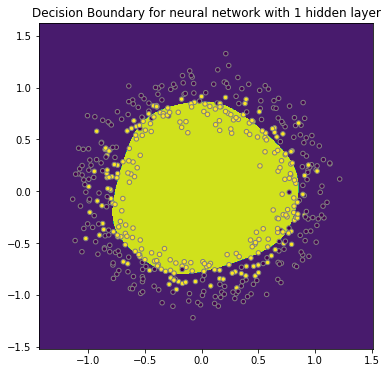

In [32]:
parameters = nn_model(X_nn, Y_nn, n_1 = 6, num_iter = 10000, print_cost = True)

# Plot the decision boundary
plot_decision_boundary(lambda X: predict(parameters, X.T)) 
plt.title("Decision Boundary for neural network with 1 hidden layer")

In [33]:
nn_predict = predict(parameters, X.T)

In [34]:
print ('The Multi-Layer Perceptron model has an accuracy of: ' 
       + str(np.sum(nn_predict == Y)/sample_size*100) + '%')

The Multi-Layer Perceptron model has an accuracy of: 74.8%


# 4. Summary 

In this lab, you learned how to create a "deeper" (yet still shallow) neural network, with tanh activation functions in the hidden layer. You noticed how you can notably improve results compared to a logistic regression model! Hopefully, this illustrates well why neural networks are so useful. 

Things you can do from here:
- Increase/decrease the number of nodes in the hidden layer
- Change learning rate alpha.
- Change the noise parameter in your data set.

# 5. Sources

https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb --> helper function

http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

https://beckernick.github.io/neural-network-scratch/

http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html